## From the article

# Implementing a distance-based classifier with a quantum interference circuit

###  M. Schuld et al 2017 EPL 119 60002

# Preparing the data

In [1]:
import numpy as np
import pandas as pd

In [2]:
iris = pd.read_csv("Iris/iris.data",header=None,names=["f0","f1","f2","f3","class"])

In [3]:
setosa = iris[iris["class"] == "Iris-setosa"].loc[:,["f0","f1","class"]]
# setosa.loc[:,"class"] = -1
setosa["color"] = "Red"
setosa["marker"] = "o"

In [4]:
versicolor = iris[iris["class"] == "Iris-versicolor"].loc[:,["f0","f1","class"]]
# versicolor.loc[:,"class"] = 1
versicolor["color"] = "Blue"
versicolor["marker"] = "x"

In [5]:
virginica = iris[iris["class"] == "Iris-virginica"].loc[:,["f0","f1","class"]]
# virginica.loc[:,"class"] = 1
virginica["color"] = "Green"
virginica["marker"] = "."
virginica.iloc[:,[0,1]]

,f0,f1
100,6.3,3.3
101,5.8,2.7
102,7.1,3.0
103,6.3,2.9
104,6.5,3.0
105,7.6,3.0
106,4.9,2.5
107,7.3,2.9
108,6.7,2.5
109,7.2,3.6


In [6]:
data = pd.concat([setosa,versicolor])

In [6]:
data = pd.concat([versicolor,virginica])

In [58]:
data = pd.concat([setosa,versicolor,virginica])

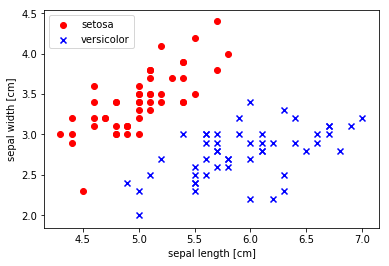

In [8]:
import matplotlib.pyplot as plt
plt.scatter(data.to_numpy()[:50,0], data.to_numpy()[:50,1], color="red", marker="o", label="setosa")
plt.scatter(data.to_numpy()[50:100,0], data.to_numpy()[50:100,1], color="blue", marker="x", label="versicolor")

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/iris2features.png', dpi=300)
plt.show()
# data.plot.scatter(x="f0", y="f1", c=data.color, marker=data.marker)

In [9]:
import matplotlib.pyplot as plt

lw = 1

def prePlotIris(data,x,y):
    X = data[data["class"] == "Iris-setosa"]
    plt.scatter(X[x],X[y],color="red",marker="o",edgecolor='black', linewidth=lw,label="setosa")
    X = data[data["class"] == "Iris-versicolor"]
    plt.scatter(X[x],X[y],color="blue",marker="o",edgecolor='black', linewidth=lw,label="versicolor")
    X = data[data["class"] == "Iris-virginica"]
    plt.scatter(X[x],X[y],color="yellow",marker="o",edgecolor='black', linewidth=lw,label="virginica")
    
    plt.xlabel('sepal length in cm')
    plt.ylabel('sepal width in cm')
    plt.legend(loc='upper left')

def plotIris(data,x,y):
    prePlotIris(data,x,y)
    plt.show()

def saveIris(data,x,y,saveName):
    prePlotIris(data,x,y)
    plt.savefig('images/'+saveName, dpi=300)

In [61]:
# data.mean()
# data["f0"] -= data.mean()[0]
# data["f1"] -= data.mean()[1]

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.iloc[:,[0,1]] = scaler.fit_transform(data.iloc[:,[0,1]])

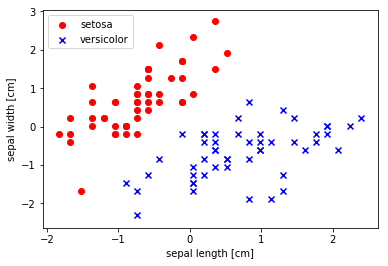

In [11]:
plt.scatter(data.to_numpy()[:50,0], data.to_numpy()[:50,1], color="red", marker="o", label="setosa")
plt.scatter(data.to_numpy()[50:100,0], data.to_numpy()[50:100,1], color="blue", marker="x", label="versicolor")

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/iris2scaled.png', dpi=300)
plt.show()

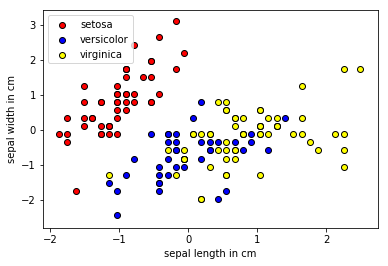

In [65]:
saveIris(data,"f0","f1",'iris4scaled')

In [12]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [13]:
for i in data.index:
    v = [data.loc[i,"f0"],data.loc[i,"f1"]]
    v = normalize(v)
    data.loc[i,"f0"], data.loc[i,"f1"] = v[0], v[1]

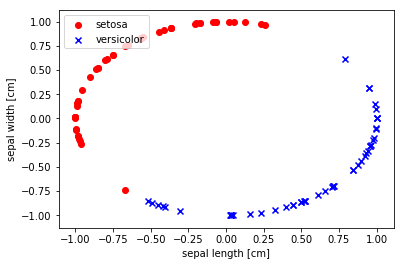

In [14]:
plt.scatter(data.to_numpy()[:50,0], data.to_numpy()[:50,1], color="red", marker="o", label="setosa")
plt.scatter(data.to_numpy()[50:100,0], data.to_numpy()[50:100,1], color="blue", marker="x", label="versicolor")

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/iris2normalized.png', dpi=300)
plt.show()

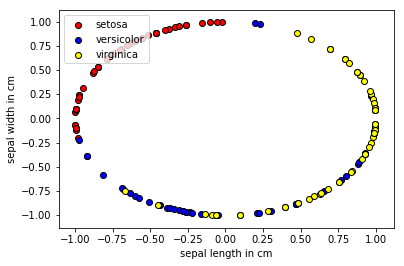

In [69]:
saveIris(data,"f0","f1",'iris4normalized.png')

In [15]:
setosa.head()

,f0,f1,class,color,marker
0,5.1,3.5,Iris-setosa,Red,o
1,4.9,3.0,Iris-setosa,Red,o
2,4.7,3.2,Iris-setosa,Red,o
3,4.6,3.1,Iris-setosa,Red,o
4,5.0,3.6,Iris-setosa,Red,o


In [16]:
# For setosa and versicolor
vectors = data.loc[[33,85,28,56],["f0","f1","class"]]
vectors["label"], vectors["angle"] = ["x0 (t0)","x1 (t1)","x' (x0)","x'' (x1)"], [round(np.pi,3),1.325,4.304,3.036]
vectors

,f0,f1,class,label,angle
33,0.019449,0.999811,Iris-setosa,x0 (t0),3.142
85,0.788610,0.614894,Iris-versicolor,x1 (t1),1.325
28,-0.549104,0.835754,Iris-setosa,x' (x0),4.304
56,0.948221,0.317610,Iris-versicolor,x'' (x1),3.036


In [21]:
# For versicolor and virginica
vectors = data.loc[[50,145,53,149],["f0","f1","class"]]
vectors["label"] = ["t0","t1","x0","x1"]
vectors

,f0,f1,class,label
50,0.748732,0.662872,Iris-versicolor,t0
145,0.864230,0.503096,Iris-virginica,t1
53,-0.555907,-0.831245,Iris-versicolor,x0
149,-0.817559,0.575845,Iris-virginica,x1


In [17]:
f0 = vectors.columns.get_loc("f0")
f2 = vectors.columns.get_loc("f1")

In [18]:
t0 = np.arctan(vectors.iloc[0,f2] / vectors.iloc[0,f0]) * 2 % (2 * np.pi)

In [19]:
t1 = np.arctan(vectors.iloc[1,f2] / vectors.iloc[1,f0]) * 2 % (2 * np.pi)

In [20]:
x0 = np.arctan(vectors.iloc[2,f2] / vectors.iloc[2,f0]) * 2 % (2 * np.pi)

In [21]:
x1 = np.arctan(vectors.iloc[3,f2] / vectors.iloc[3,f0]) * 2 % (2 * np.pi)

# Building the quantum circuit

In [22]:
import qiskit
from qiskit import IBMQ
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram
import qiskit.aqua.circuits.gates.controlled_ry_gates

In [23]:
str(1+1+1+1) + ' qubits'

'4 qubits'

In [25]:
a = QuantumRegister(1,'a')
m = QuantumRegister(1,'m')
i = QuantumRegister(1,'i')
c = QuantumRegister(1,'c')
b = ClassicalRegister(2, 'bit')
circuit = QuantumCircuit(a,m,i,c,b)

circuit.h(a)
circuit.h(m)

circuit.barrier()

circuit.cry(x0,a[0],i[0])
circuit.x(a)

circuit.barrier()

# circuit.ccx(a,m,i)
circuit.mcry(t0,a[:]+m[:],i[0],None)
circuit.x(m)

circuit.barrier()

circuit.mcry(t1,a[:]+m[:],i[0],None)

circuit.barrier()

circuit.cx(m,c)

circuit.barrier()

circuit.h(a)
circuit.measure(a,b[0])
circuit.measure(c,b[1])

#circuit.draw(output='mpl')#.savefig("images/base_circuit.png", dpi=300)


Total counts are: {'01': 335, '10': 2214, '11': 1905, '00': 3738}


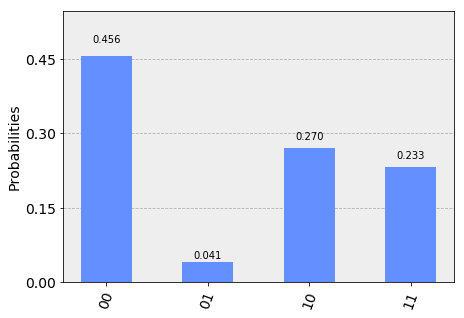

In [26]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=8192)
result = job.result()
counts = result.get_counts(circuit)
print("\nTotal counts are:",counts)
plot_histogram(counts)

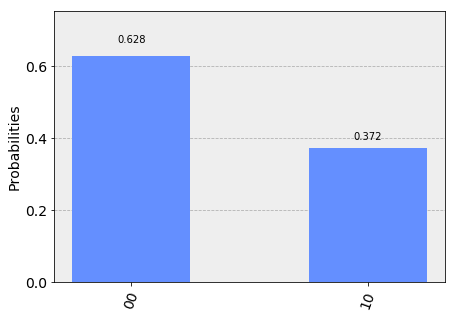

In [27]:
goodCounts = {k: counts[k] for k in counts.keys() & {'00', '10'}}
plot_histogram(goodCounts)#.savefig("images/misura_versicolor_filtrata.png", dpi=300)

# Real hardware

In [24]:
provider = IBMQ.load_account()

In [25]:
print("Available backends:")
provider.backends()

Available backends:


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [26]:
from qiskit.providers.ibmq import least_busy

large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmq_16_melbourne


In [68]:
backend = provider.backends()[4]

In [27]:
backend.name()

'ibmq_16_melbourne'

In [28]:
from qiskit.tools.monitor import job_monitor
# Number of shots to run the program (experiment);
# maximum is 8192 shots.
shots = 8192
# Maximum number of credits to spend on executions.
max_credits = 5

job_exp = execute(circuit, backend, shots=shots, max_credits=max_credits)
job_monitor(job_exp)

Job Status: job has been cancelled  


In [29]:
job_exp = backend.retrieve_job('5d718fe6b2eb4a0012fc59a1')

In [30]:
result_exp = job_exp.result()

In [32]:
counts_exp = result_exp.get_counts()

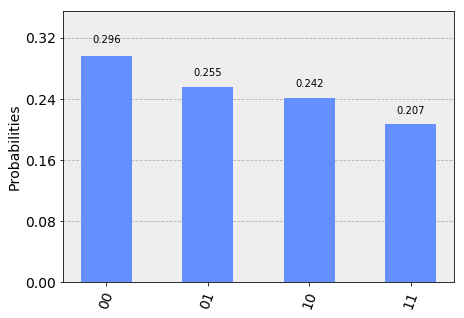

In [33]:
plot_histogram(counts_exp)

In [42]:
goodCounts_exp = {k: counts_exp[k] for k in counts_exp.keys() & {'00', '10'}}

In [45]:
plot_histogram(goodCounts_exp).savefig("images/misura_setosa_sperimentale.png", dpi=300)